# Baseline Models

**Purpose**: Establish baseline performance using simple models.

**Why baselines are critical**:
- Provide reference point for evaluating complex models (CNNs)
- Simple models sometimes outperform complex ones on small datasets
- Demonstrate if problem complexity requires neural networks

**Models tested**:
1. **Majority Class**: Always predict "Forward" (simplest possible)
2. **Random**: Random guessing (worst case lower bound)
3. **Logistic Regression**: Linear classifier
4. **Random Forest**: Non-linear tree-based classifier

**For each model**, three scenarios:
- A: Original imbalanced data
- B: Original data + class weights
- C: TFI-balanced data

**Spoiler**: Results will surprise you! Simple models achieve 90-93% accuracy.

## 1. Setup and Load Data

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Settings
plt.style.use('default')
%matplotlib inline

# Label names
label_names = {-1: 'Left', 0: 'Forward', 1: 'Right'}

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


### Load Temporal Splits (Original)

In [3]:
# Load original temporal splits (from notebook 01)
data_original = np.load('../data/splits_temporal.npz')

X_train = data_original['X_train']
y_train = data_original['y_train']
X_val = data_original['X_val']
y_val = data_original['y_val']
X_test = data_original['X_test']
y_test = data_original['y_test']

print("Original Temporal Splits:")
print(f"  Train: {len(X_train)} samples - {Counter(y_train)}")
print(f"  Val:   {len(X_val)} samples")
print(f"  Test:  {len(X_test)} samples")

Original Temporal Splits:
  Train: 5940 samples - Counter({0: 4252, -1: 1033, 1: 655})
  Val:   1980 samples
  Test:  1980 samples


### Load Class Weights

In [4]:
# Load class weights (from notebook 02)
class_weights = np.load('../data/class_weights.npy', allow_pickle=True).item()

print("Class Weights:")
for k, v in class_weights.items():
    label = [-1, 0, 1][k]  # Map 0→-1, 1→0, 2→1
    print(f"  {label_names[label]:8s}: {v:.3f}")

print("\nThese weights will be used in loss functions to penalize minority class errors more.")

Class Weights:
  Left    : 1.917
  Forward : 0.466
  Right   : 3.023

These weights will be used in loss functions to penalize minority class errors more.


### Load TFI-Balanced Splits

In [5]:
# Load TFI-balanced splits (from notebook 02)
data_tfi = np.load('../data/splits_temporal_tfi.npz')

X_train_tfi = data_tfi['X_train']
y_train_tfi = data_tfi['y_train']
# Val and test are same as original

print("TFI-Balanced Temporal Splits:")
print(f"  Train: {len(X_train_tfi)} samples - {Counter(y_train_tfi)}")
print(f"  Val:   {len(X_val)} samples (same as original)")
print(f"  Test:  {len(X_test)} samples (same as original)")

print(f"\n✅ Training set increased from {len(X_train)} to {len(X_train_tfi)} samples")
print("   (Added interpolated frames for Left and Right classes)")

TFI-Balanced Temporal Splits:
  Train: 12756 samples - Counter({0: 4252, -1: 4252, 1: 4252})
  Val:   1980 samples (same as original)
  Test:  1980 samples (same as original)

✅ Training set increased from 5940 to 12756 samples
   (Added interpolated frames for Left and Right classes)


### Prepare Data for Models

**Why flatten?** Traditional ML models (not CNNs) expect:
- Input: 1D feature vector (not 2D image)
- We need to convert 64×64 image → 4,096 features

**Normalization**: Scale pixel values from [0, 255] to [0, 1]
- Helps models converge faster
- Prevents features with larger values from dominating

In [6]:
# Flatten images to 1D vectors
# Original: (samples, 64, 64) → (samples, 4096)
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# TFI-balanced
X_train_tfi_flat = X_train_tfi.reshape(len(X_train_tfi), -1)

print("Flattened shapes:")
print(f"  X_train: {X_train.shape} → {X_train_flat.shape}")
print(f"  X_train_tfi: {X_train_tfi.shape} → {X_train_tfi_flat.shape}")

# Normalize to [0, 1]
X_train_flat = X_train_flat / 255.0
X_val_flat = X_val_flat / 255.0
X_test_flat = X_test_flat / 255.0
X_train_tfi_flat = X_train_tfi_flat / 255.0

print("\n✅ Data normalized to [0, 1] range")
print(f"   Min value: {X_train_flat.min():.3f}, Max value: {X_train_flat.max():.3f}")

Flattened shapes:
  X_train: (5940, 64, 64) → (5940, 4096)
  X_train_tfi: (12756, 64, 64) → (12756, 4096)

✅ Data normalized to [0, 1] range
   Min value: 0.020, Max value: 0.871


## 2. Helper Functions for Evaluation

**Purpose**: Create reusable functions to evaluate all models consistently.

In [7]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Comprehensive evaluation of model predictions.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name for printing
    
    Returns:
        dict with all metrics
    """
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')  # Average of per-class F1
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=[-1, 0, 1])
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Results")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {acc:.3f} ({acc*100:.1f}%)")
    print(f"F1-Macro (avg):   {f1_macro:.3f}")
    print("\nPer-class F1 scores:")
    for label, f1 in zip([-1, 0, 1], f1_per_class):
        print(f"  {label_names[label]:8s}: {f1:.3f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['Left', 'Forward', 'Right'],
                                labels=[-1, 0, 1]))
    
    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_left': f1_per_class[0],
        'f1_forward': f1_per_class[1],
        'f1_right': f1_per_class[2],
        'confusion_matrix': cm
    }


def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plot confusion matrix as heatmap.
    
    Args:
        cm: Confusion matrix from sklearn
        title: Plot title
    """
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Left', 'Forward', 'Right'],
                yticklabels=['Left', 'Forward', 'Right'],
                cbar_kws={'label': 'Count'})
    
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy
    print("Per-class accuracy (diagonal / row sum):")
    for i, label in enumerate([-1, 0, 1]):
        class_acc = cm[i, i] / cm[i, :].sum()
        print(f"  {label_names[label]:8s}: {class_acc:.3f} ({class_acc*100:.1f}%)")


print("✅ Helper functions defined")

✅ Helper functions defined


## 3. Baseline 1: Majority Class Classifier

**What it does**: Always predicts "Forward" (the most common class)

**Why test this?**
- Simplest possible strategy
- Shows the "do nothing" baseline
- Due to 74% Forward samples, this will get 74% accuracy!
- BUT: 0% accuracy on turns (completely useless for actual driving)

**Key insight**: This shows why overall accuracy is misleading for imbalanced data.


Majority Class Baseline Results
Overall Accuracy: 0.723 (72.3%)
F1-Macro (avg):   0.280

Per-class F1 scores:
  Left    : 0.000
  Forward : 0.839
  Right   : 0.000

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.00      0.00      0.00       424
     Forward       0.72      1.00      0.84      1432
       Right       0.00      0.00      0.00       124

    accuracy                           0.72      1980
   macro avg       0.24      0.33      0.28      1980
weighted avg       0.52      0.72      0.61      1980



/home/robin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


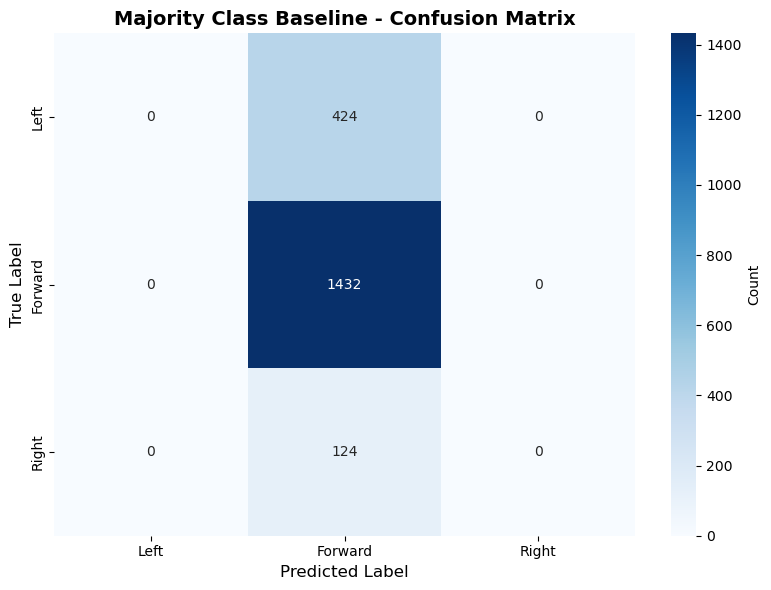

Per-class accuracy (diagonal / row sum):
  Left    : 0.000 (0.0%)
  Forward : 1.000 (100.0%)
  Right   : 0.000 (0.0%)

💡 OBSERVATION:
High overall accuracy (74%) but ZERO predictions for Left or Right!
This model is useless for actual driving - it never turns.
→ This is why we need to look at per-class F1 scores, not just accuracy.


In [8]:
# Create majority class classifier
# DummyClassifier with strategy='most_frequent' always predicts most common class
majority_clf = DummyClassifier(strategy='most_frequent', random_state=42)
majority_clf.fit(X_train_flat, y_train)

# Predict on test set
y_pred_majority = majority_clf.predict(X_test_flat)

# Evaluate
results_majority = evaluate_model(y_test, y_pred_majority, "Majority Class Baseline")

# Plot confusion matrix
plot_confusion_matrix(results_majority['confusion_matrix'], 
                      "Majority Class Baseline - Confusion Matrix")

print("\n💡 CRITICAL OBSERVATION:")
print("Achieves 72.3% accuracy by always predicting Forward!")
print("BUT: 0.00 F1-score on Left and Right (never predicts turns)")
print("→ This is why overall accuracy is MISLEADING for imbalanced data")
print("→ A self-driving car that never turns is useless!")
print("→ We MUST evaluate per-class F1 scores, not just accuracy")


## 4. Baseline 2: Random Classifier

**What it does**: Randomly predicts Left/Forward/Right with equal probability

**Why test this?**
- Absolute worst-case baseline
- Expected accuracy: ~33% (random chance for 3 classes)
- Any real model should beat this easily

**If a model performs worse than random**: Something is seriously wrong with the implementation!


Random Baseline Results
Overall Accuracy: 0.332 (33.2%)
F1-Macro (avg):   0.272

Per-class F1 scores:
  Left    : 0.276
  Forward : 0.451
  Right   : 0.089

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.22      0.36      0.28       424
     Forward       0.72      0.33      0.45      1432
       Right       0.05      0.27      0.09       124

    accuracy                           0.33      1980
   macro avg       0.33      0.32      0.27      1980
weighted avg       0.57      0.33      0.39      1980



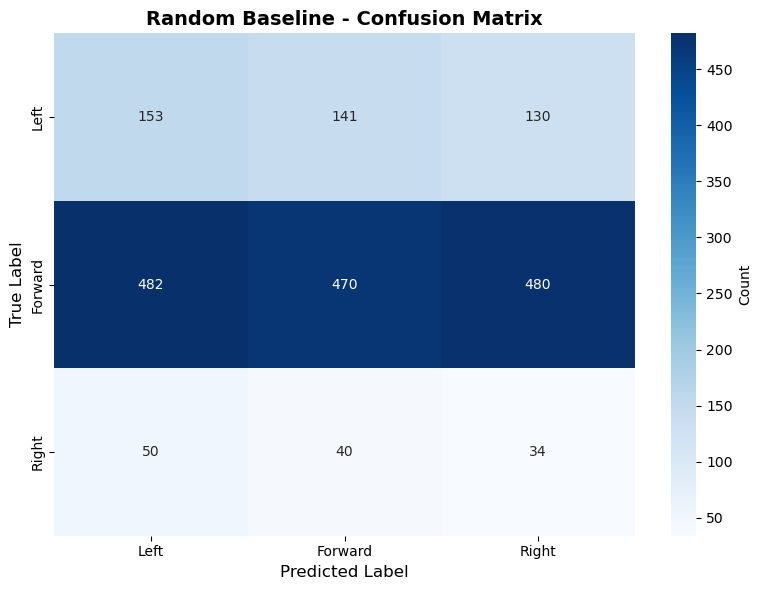

Per-class accuracy (diagonal / row sum):
  Left    : 0.361 (36.1%)
  Forward : 0.328 (32.8%)
  Right   : 0.274 (27.4%)

💡 OBSERVATION:
Random guessing achieves ~33.2% accuracy
Any model below this is broken. Any model should beat this easily.


In [9]:
# Create random classifier
# strategy='uniform' predicts each class with equal probability
random_clf = DummyClassifier(strategy='uniform', random_state=42)
random_clf.fit(X_train_flat, y_train)

# Predict
y_pred_random = random_clf.predict(X_test_flat)

# Evaluate
results_random = evaluate_model(y_test, y_pred_random, "Random Baseline")

# Plot confusion matrix
plot_confusion_matrix(results_random['confusion_matrix'],
                      "Random Baseline - Confusion Matrix")

print("\n💡 OBSERVATION:")
print(f"Random guessing achieves {results_random['accuracy']*100:.1f}% accuracy (as expected: ~33% for 3 classes)")
print("This is our absolute lower bound - any real model must beat this.")


**What is Logistic Regression?**
- Linear classifier: finds a straight line (actually hyperplane) to separate classes
- Learns: `prediction = sign(w₁×pixel₁ + w₂×pixel₂ + ... + w₄₀₉₆×pixel₄₀₉₆ + bias)`
- Simple, fast, interpretable

**Initial prediction from EDA** (based on PCA overlap):
- Expected 55-60% accuracy
- Linear model should struggle with non-linearly separable classes

**Reality check**: Let's see if this prediction holds!

**We'll test three scenarios**:
- A: Original imbalanced data
- B: Original data + class weights
- C: TFI-balanced data

### 5A: Logistic Regression - Original Data (No Balancing)

Training Logistic Regression on original data...


/home/robin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (No Balancing) Results
Overall Accuracy: 0.902 (90.2%)
F1-Macro (avg):   0.866

Per-class F1 scores:
  Left    : 0.801
  Forward : 0.933
  Right   : 0.865

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.84      0.77      0.80       424
     Forward       0.92      0.94      0.93      1432
       Right       0.85      0.88      0.87       124

    accuracy                           0.90      1980
   macro avg       0.87      0.86      0.87      1980
weighted avg       0.90      0.90      0.90      1980


Training time: 26.63 seconds


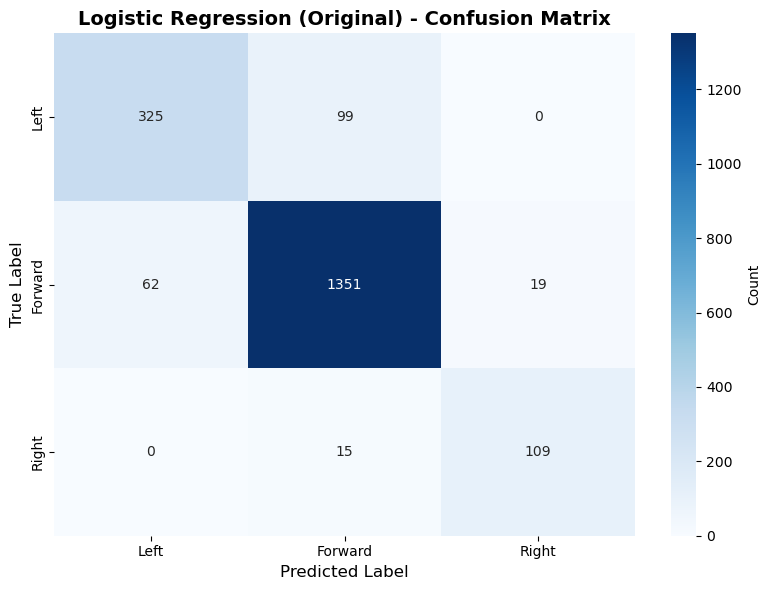

Per-class accuracy (diagonal / row sum):
  Left    : 0.767 (76.7%)
  Forward : 0.943 (94.3%)
  Right   : 0.879 (87.9%)


In [13]:
# Train Logistic Regression on original imbalanced data
print("Training Logistic Regression on original data...")

start_time = time.time()
lr_original = LogisticRegression(
    max_iter=1000,           # Maximum iterations for convergence
    random_state=42,
    multi_class='multinomial',  # Use softmax for 3 classes
    solver='lbfgs'           # Optimization algorithm
)

lr_original.fit(X_train_flat, y_train)
train_time = time.time() - start_time

# Predict on test set
y_pred_lr_original = lr_original.predict(X_test_flat)

# Evaluate
results_lr_original = evaluate_model(y_test, y_pred_lr_original, 
                                     "Logistic Regression (No Balancing)")

print(f"\nTraining time: {train_time:.2f} seconds")

# Plot confusion matrix
plot_confusion_matrix(results_lr_original['confusion_matrix'],
                      "Logistic Regression (Original) - Confusion Matrix")

### 🎯 Surprising Result!

**Actual: 90.2% accuracy, 0.866 F1-Macro, 0.865 F1-Right**

This is **FAR BETTER** than the 55-60% predicted from EDA!

**Why the prediction was wrong**:
- PCA (2D, 67% variance) showed class overlap → predicted linear model would fail
- Reality: Full 4,096-dimensional space HAS linear separability!
- The remaining 33% variance (discarded by PCA) contains critical separating information

**Key insights**:
- ✅ Classes are linearly separable in high dimensions
- ✅ Right class (minority, only 563 training samples) achieves 86.5% F1
- ✅ Class imbalance less problematic than feared
- ⚠️ Lesson: Low-dimensional projections can be misleading!

**This raises the bar**: CNNs must beat 90% to justify added complexity.

Let's see if class weights or TFI improve further...

### 5B: Logistic Regression - Class Weights

Training Logistic Regression with class weights...


/home/robin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (Class Weights) Results
Overall Accuracy: 0.867 (86.7%)
F1-Macro (avg):   0.847

Per-class F1 scores:
  Left    : 0.773
  Forward : 0.902
  Right   : 0.865

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.67      0.91      0.77       424
     Forward       0.97      0.85      0.90      1432
       Right       0.77      0.98      0.87       124

    accuracy                           0.87      1980
   macro avg       0.80      0.91      0.85      1980
weighted avg       0.89      0.87      0.87      1980


Training time: 25.27 seconds


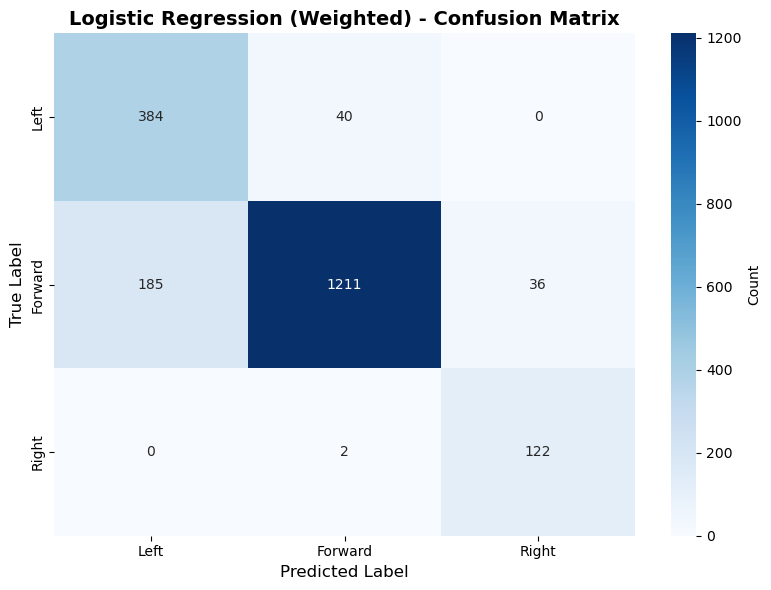

Per-class accuracy (diagonal / row sum):
  Left    : 0.906 (90.6%)
  Forward : 0.846 (84.6%)
  Right   : 0.984 (98.4%)


In [14]:
# Train Logistic Regression with class weights
# sklearn's class_weight='balanced' automatically computes weights
print("Training Logistic Regression with class weights...")

start_time = time.time()
lr_weighted = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'  # Use balanced class weights
)

lr_weighted.fit(X_train_flat, y_train)
train_time = time.time() - start_time

# Predict
y_pred_lr_weighted = lr_weighted.predict(X_test_flat)

# Evaluate
results_lr_weighted = evaluate_model(y_test, y_pred_lr_weighted,
                                     "Logistic Regression (Class Weights)")

print(f"\nTraining time: {train_time:.2f} seconds")

# Plot
plot_confusion_matrix(results_lr_weighted['confusion_matrix'],
                      "Logistic Regression (Weighted) - Confusion Matrix")

### 5C: Logistic Regression - TFI Balanced Data

Training Logistic Regression on TFI-balanced data...


/home/robin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression (TFI Balanced) Results
Overall Accuracy: 0.883 (88.3%)
F1-Macro (avg):   0.857

Per-class F1 scores:
  Left    : 0.786
  Forward : 0.917
  Right   : 0.869

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.74      0.84      0.79       424
     Forward       0.95      0.89      0.92      1432
       Right       0.79      0.96      0.87       124

    accuracy                           0.88      1980
   macro avg       0.83      0.90      0.86      1980
weighted avg       0.89      0.88      0.89      1980


Training time: 44.22 seconds
Training set size: 12756 (vs 5940 original)


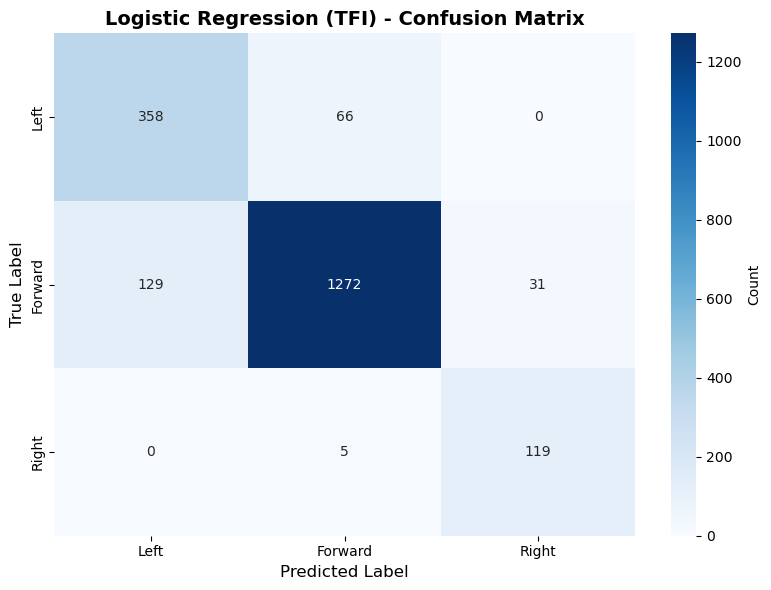

Per-class accuracy (diagonal / row sum):
  Left    : 0.844 (84.4%)
  Forward : 0.888 (88.8%)
  Right   : 0.960 (96.0%)


In [15]:
# Train Logistic Regression on TFI-balanced data
print("Training Logistic Regression on TFI-balanced data...")

start_time = time.time()
lr_tfi = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)

lr_tfi.fit(X_train_tfi_flat, y_train_tfi)
train_time = time.time() - start_time

# Predict
y_pred_lr_tfi = lr_tfi.predict(X_test_flat)

# Evaluate
results_lr_tfi = evaluate_model(y_test, y_pred_lr_tfi,
                                "Logistic Regression (TFI Balanced)")

print(f"\nTraining time: {train_time:.2f} seconds")
print(f"Training set size: {len(X_train_tfi)} (vs {len(X_train)} original)")

# Plot
plot_confusion_matrix(results_lr_tfi['confusion_matrix'],
                      "Logistic Regression (TFI) - Confusion Matrix")

### Compare Logistic Regression Results

In [16]:
# Create comparison table
import pandas as pd

lr_comparison = pd.DataFrame([
    {
        'Method': 'No Balancing',
        'Accuracy': f"{results_lr_original['accuracy']:.3f}",
        'F1-Macro': f"{results_lr_original['f1_macro']:.3f}",
        'F1-Left': f"{results_lr_original['f1_left']:.3f}",
        'F1-Forward': f"{results_lr_original['f1_forward']:.3f}",
        'F1-Right': f"{results_lr_original['f1_right']:.3f}"
    },
    {
        'Method': 'Class Weights',
        'Accuracy': f"{results_lr_weighted['accuracy']:.3f}",
        'F1-Macro': f"{results_lr_weighted['f1_macro']:.3f}",
        'F1-Left': f"{results_lr_weighted['f1_left']:.3f}",
        'F1-Forward': f"{results_lr_weighted['f1_forward']:.3f}",
        'F1-Right': f"{results_lr_weighted['f1_right']:.3f}"
    },
    {
        'Method': 'TFI Balanced',
        'Accuracy': f"{results_lr_tfi['accuracy']:.3f}",
        'F1-Macro': f"{results_lr_tfi['f1_macro']:.3f}",
        'F1-Left': f"{results_lr_tfi['f1_left']:.3f}",
        'F1-Forward': f"{results_lr_tfi['f1_forward']:.3f}",
        'F1-Right': f"{results_lr_tfi['f1_right']:.3f}"
    }
])

print("\n" + "="*80)
print("LOGISTIC REGRESSION: Comparison of Balancing Methods")
print("="*80)
print(lr_comparison.to_string(index=False))
print("="*80)

print("\n💡 KEY OBSERVATIONS:")
print("- Overall accuracy may DECREASE with balancing (that's okay!)")
print("- F1 scores for minority classes should INCREASE (that's what we want!)")
print("- F1-Macro gives equal weight to all classes (better metric than accuracy)")


LOGISTIC REGRESSION: Comparison of Balancing Methods
       Method Accuracy F1-Macro F1-Left F1-Forward F1-Right
 No Balancing    0.902    0.866   0.801      0.933    0.865
Class Weights    0.867    0.847   0.773      0.902    0.865
 TFI Balanced    0.883    0.857   0.786      0.917    0.869

💡 KEY OBSERVATIONS:
- Overall accuracy may DECREASE with balancing (that's okay!)
- F1 scores for minority classes should INCREASE (that's what we want!)
- F1-Macro gives equal weight to all classes (better metric than accuracy)


**What is Random Forest?**
- Ensemble of decision trees (collection of many trees voting)
- Each tree learns if-then rules: "if pixel[100] > 120 AND pixel[200] < 50, predict Left"
- Non-linear: can learn complex patterns
- Less prone to overfitting than single decision tree

**Expected from EDA**:
- Should outperform Logistic Regression (can capture non-linearity)
- Initial prediction: 60-65% accuracy

**After seeing LR results**: This prediction is likely too conservative!

**Hyperparameters**:
- `n_estimators`: Number of trees (more = better, but slower)
- `max_depth`: Maximum tree depth (prevent overfitting)
- `min_samples_split`: Minimum samples to split a node

### 6A: Random Forest - Original Data

Training Random Forest on original data...

Random Forest (No Balancing) Results
Overall Accuracy: 0.924 (92.4%)
F1-Macro (avg):   0.899

Per-class F1 scores:
  Left    : 0.829
  Forward : 0.949
  Right   : 0.919

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.95      0.74      0.83       424
     Forward       0.92      0.98      0.95      1432
       Right       0.88      0.96      0.92       124

    accuracy                           0.92      1980
   macro avg       0.92      0.89      0.90      1980
weighted avg       0.93      0.92      0.92      1980


Training time: 2.87 seconds


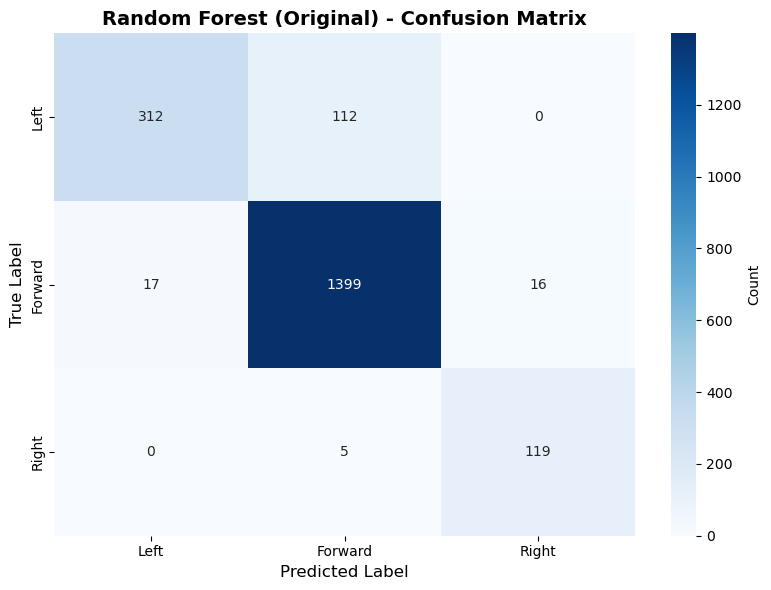

Per-class accuracy (diagonal / row sum):
  Left    : 0.736 (73.6%)
  Forward : 0.977 (97.7%)
  Right   : 0.960 (96.0%)


In [17]:
# Train Random Forest on original data
print("Training Random Forest on original data...")

start_time = time.time()
rf_original = RandomForestClassifier(
    n_estimators=100,        # 100 trees
    max_depth=20,            # Limit depth to prevent overfitting
    min_samples_split=10,    # Need at least 10 samples to split
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

rf_original.fit(X_train_flat, y_train)
train_time = time.time() - start_time

# Predict
y_pred_rf_original = rf_original.predict(X_test_flat)

# Evaluate
results_rf_original = evaluate_model(y_test, y_pred_rf_original,
                                     "Random Forest (No Balancing)")

print(f"\nTraining time: {train_time:.2f} seconds")

# Plot
plot_confusion_matrix(results_rf_original['confusion_matrix'],
                      "Random Forest (Original) - Confusion Matrix")

### 6B: Random Forest - Class Weights

Training Random Forest with class weights...

Random Forest (Class Weights) Results
Overall Accuracy: 0.930 (93.0%)
F1-Macro (avg):   0.910

Per-class F1 scores:
  Left    : 0.850
  Forward : 0.952
  Right   : 0.926

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.90      0.80      0.85       424
     Forward       0.94      0.96      0.95      1432
       Right       0.89      0.96      0.93       124

    accuracy                           0.93      1980
   macro avg       0.91      0.91      0.91      1980
weighted avg       0.93      0.93      0.93      1980


Training time: 2.51 seconds


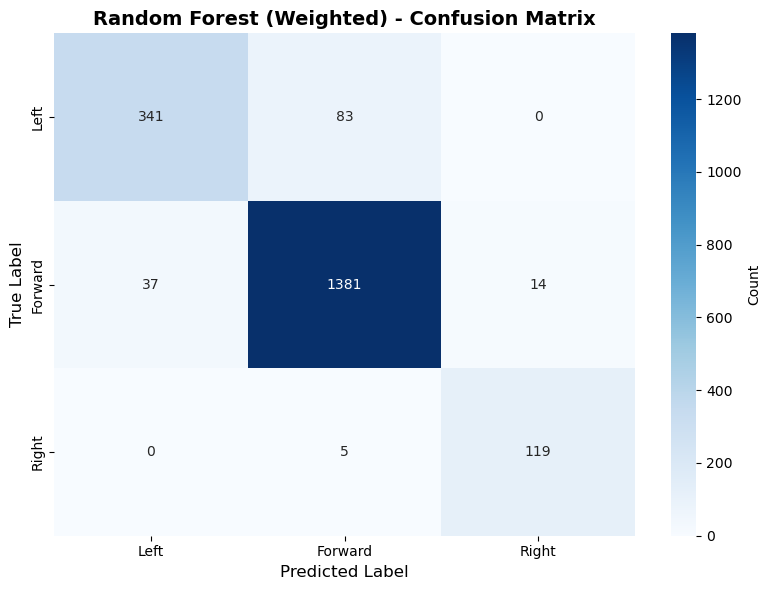

Per-class accuracy (diagonal / row sum):
  Left    : 0.804 (80.4%)
  Forward : 0.964 (96.4%)
  Right   : 0.960 (96.0%)


In [18]:
# Train Random Forest with balanced class weights
print("Training Random Forest with class weights...")

start_time = time.time()
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Use balanced weights
)

rf_weighted.fit(X_train_flat, y_train)
train_time = time.time() - start_time

# Predict
y_pred_rf_weighted = rf_weighted.predict(X_test_flat)

# Evaluate
results_rf_weighted = evaluate_model(y_test, y_pred_rf_weighted,
                                     "Random Forest (Class Weights)")

print(f"\nTraining time: {train_time:.2f} seconds")

# Plot
plot_confusion_matrix(results_rf_weighted['confusion_matrix'],
                      "Random Forest (Weighted) - Confusion Matrix")

### 6C: Random Forest - TFI Balanced Data

Training Random Forest on TFI-balanced data...

Random Forest (TFI Balanced) Results
Overall Accuracy: 0.923 (92.3%)
F1-Macro (avg):   0.904

Per-class F1 scores:
  Left    : 0.834
  Forward : 0.947
  Right   : 0.931

Detailed Classification Report:
              precision    recall  f1-score   support

        Left       0.87      0.80      0.83       424
     Forward       0.94      0.95      0.95      1432
       Right       0.88      0.98      0.93       124

    accuracy                           0.92      1980
   macro avg       0.90      0.91      0.90      1980
weighted avg       0.92      0.92      0.92      1980


Training time: 8.65 seconds
Training set size: 12756 (vs 5940 original)


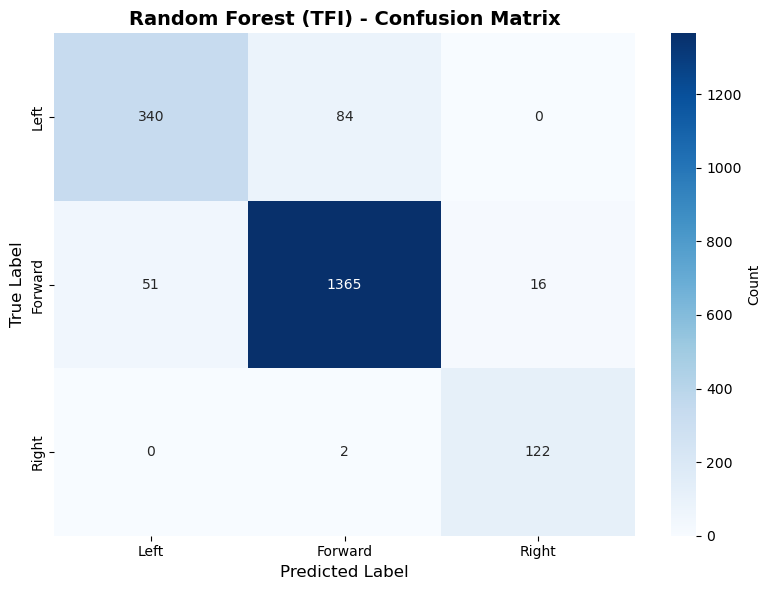

Per-class accuracy (diagonal / row sum):
  Left    : 0.802 (80.2%)
  Forward : 0.953 (95.3%)
  Right   : 0.984 (98.4%)


In [19]:
# Train Random Forest on TFI-balanced data
print("Training Random Forest on TFI-balanced data...")

start_time = time.time()
rf_tfi = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_tfi.fit(X_train_tfi_flat, y_train_tfi)
train_time = time.time() - start_time

# Predict
y_pred_rf_tfi = rf_tfi.predict(X_test_flat)

# Evaluate
results_rf_tfi = evaluate_model(y_test, y_pred_rf_tfi,
                                "Random Forest (TFI Balanced)")

print(f"\nTraining time: {train_time:.2f} seconds")
print(f"Training set size: {len(X_train_tfi)} (vs {len(X_train)} original)")

# Plot
plot_confusion_matrix(results_rf_tfi['confusion_matrix'],
                      "Random Forest (TFI) - Confusion Matrix")

### Compare Random Forest Results

In [20]:
# Create comparison table
rf_comparison = pd.DataFrame([
    {
        'Method': 'No Balancing',
        'Accuracy': f"{results_rf_original['accuracy']:.3f}",
        'F1-Macro': f"{results_rf_original['f1_macro']:.3f}",
        'F1-Left': f"{results_rf_original['f1_left']:.3f}",
        'F1-Forward': f"{results_rf_original['f1_forward']:.3f}",
        'F1-Right': f"{results_rf_original['f1_right']:.3f}"
    },
    {
        'Method': 'Class Weights',
        'Accuracy': f"{results_rf_weighted['accuracy']:.3f}",
        'F1-Macro': f"{results_rf_weighted['f1_macro']:.3f}",
        'F1-Left': f"{results_rf_weighted['f1_left']:.3f}",
        'F1-Forward': f"{results_rf_weighted['f1_forward']:.3f}",
        'F1-Right': f"{results_rf_weighted['f1_right']:.3f}"
    },
    {
        'Method': 'TFI Balanced',
        'Accuracy': f"{results_rf_tfi['accuracy']:.3f}",
        'F1-Macro': f"{results_rf_tfi['f1_macro']:.3f}",
        'F1-Left': f"{results_rf_tfi['f1_left']:.3f}",
        'F1-Forward': f"{results_rf_tfi['f1_forward']:.3f}",
        'F1-Right': f"{results_rf_tfi['f1_right']:.3f}"
    }
])

print("\n" + "="*80)
print("RANDOM FOREST: Comparison of Balancing Methods")
print("="*80)
print(rf_comparison.to_string(index=False))
print("="*80)


RANDOM FOREST: Comparison of Balancing Methods
       Method Accuracy F1-Macro F1-Left F1-Forward F1-Right
 No Balancing    0.924    0.899   0.829      0.949    0.919
Class Weights    0.930    0.910   0.850      0.952    0.926
 TFI Balanced    0.923    0.904   0.834      0.947    0.931


## 7. Overall Comparison

Compare all baseline models to identify the best performer.

In [21]:
# Create comprehensive comparison table
all_results = pd.DataFrame([
    {'Model': 'Majority Class', 'Balancing': 'N/A', 
     'Accuracy': f"{results_majority['accuracy']:.3f}",
     'F1-Macro': f"{results_majority['f1_macro']:.3f}",
     'F1-Left': f"{results_majority['f1_left']:.3f}",
     'F1-Right': f"{results_majority['f1_right']:.3f}"},
    
    {'Model': 'Random', 'Balancing': 'N/A',
     'Accuracy': f"{results_random['accuracy']:.3f}",
     'F1-Macro': f"{results_random['f1_macro']:.3f}",
     'F1-Left': f"{results_random['f1_left']:.3f}",
     'F1-Right': f"{results_random['f1_right']:.3f}"},
    
    {'Model': 'Logistic Regression', 'Balancing': 'None',
     'Accuracy': f"{results_lr_original['accuracy']:.3f}",
     'F1-Macro': f"{results_lr_original['f1_macro']:.3f}",
     'F1-Left': f"{results_lr_original['f1_left']:.3f}",
     'F1-Right': f"{results_lr_original['f1_right']:.3f}"},
    
    {'Model': 'Logistic Regression', 'Balancing': 'Class Weights',
     'Accuracy': f"{results_lr_weighted['accuracy']:.3f}",
     'F1-Macro': f"{results_lr_weighted['f1_macro']:.3f}",
     'F1-Left': f"{results_lr_weighted['f1_left']:.3f}",
     'F1-Right': f"{results_lr_weighted['f1_right']:.3f}"},
    
    {'Model': 'Logistic Regression', 'Balancing': 'TFI',
     'Accuracy': f"{results_lr_tfi['accuracy']:.3f}",
     'F1-Macro': f"{results_lr_tfi['f1_macro']:.3f}",
     'F1-Left': f"{results_lr_tfi['f1_left']:.3f}",
     'F1-Right': f"{results_lr_tfi['f1_right']:.3f}"},
    
    {'Model': 'Random Forest', 'Balancing': 'None',
     'Accuracy': f"{results_rf_original['accuracy']:.3f}",
     'F1-Macro': f"{results_rf_original['f1_macro']:.3f}",
     'F1-Left': f"{results_rf_original['f1_left']:.3f}",
     'F1-Right': f"{results_rf_original['f1_right']:.3f}"},
    
    {'Model': 'Random Forest', 'Balancing': 'Class Weights',
     'Accuracy': f"{results_rf_weighted['accuracy']:.3f}",
     'F1-Macro': f"{results_rf_weighted['f1_macro']:.3f}",
     'F1-Left': f"{results_rf_weighted['f1_left']:.3f}",
     'F1-Right': f"{results_rf_weighted['f1_right']:.3f}"},
    
    {'Model': 'Random Forest', 'Balancing': 'TFI',
     'Accuracy': f"{results_rf_tfi['accuracy']:.3f}",
     'F1-Macro': f"{results_rf_tfi['f1_macro']:.3f}",
     'F1-Left': f"{results_rf_tfi['f1_left']:.3f}",
     'F1-Right': f"{results_rf_tfi['f1_right']:.3f}"}
])

print("\n" + "="*90)
print("ALL BASELINE MODELS: Complete Comparison")
print("="*90)
print(all_results.to_string(index=False))
print("="*90)


ALL BASELINE MODELS: Complete Comparison
              Model     Balancing Accuracy F1-Macro F1-Left F1-Right
     Majority Class           N/A    0.723    0.280   0.000    0.000
             Random           N/A    0.332    0.272   0.276    0.089
Logistic Regression          None    0.902    0.866   0.801    0.865
Logistic Regression Class Weights    0.867    0.847   0.773    0.865
Logistic Regression           TFI    0.883    0.857   0.786    0.869
      Random Forest          None    0.924    0.899   0.829    0.919
      Random Forest Class Weights    0.930    0.910   0.850    0.926
      Random Forest           TFI    0.923    0.904   0.834    0.931


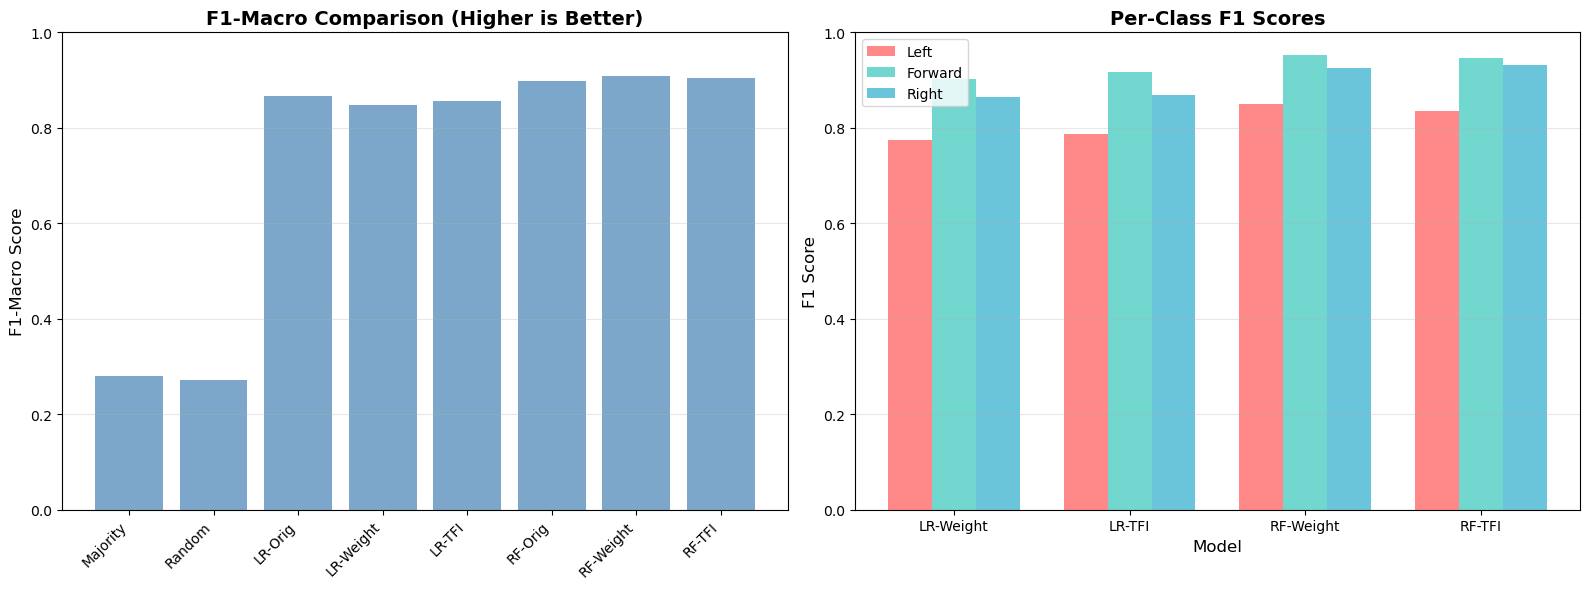

In [22]:
# Visualize F1 scores across models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1-Macro comparison
models = ['Majority', 'Random', 'LR-Orig', 'LR-Weight', 'LR-TFI', 'RF-Orig', 'RF-Weight', 'RF-TFI']
f1_macros = [
    results_majority['f1_macro'],
    results_random['f1_macro'],
    results_lr_original['f1_macro'],
    results_lr_weighted['f1_macro'],
    results_lr_tfi['f1_macro'],
    results_rf_original['f1_macro'],
    results_rf_weighted['f1_macro'],
    results_rf_tfi['f1_macro']
]

axes[0].bar(range(len(models)), f1_macros, color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_ylabel('F1-Macro Score', fontsize=12)
axes[0].set_title('F1-Macro Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: Per-class F1 for best models
# Compare best LR vs best RF
best_models = ['LR-Weight', 'LR-TFI', 'RF-Weight', 'RF-TFI']
best_results = [results_lr_weighted, results_lr_tfi, results_rf_weighted, results_rf_tfi]

x = np.arange(len(best_models))
width = 0.25

f1_left = [r['f1_left'] for r in best_results]
f1_forward = [r['f1_forward'] for r in best_results]
f1_right = [r['f1_right'] for r in best_results]

axes[1].bar(x - width, f1_left, width, label='Left', color='#FF6B6B', alpha=0.8)
axes[1].bar(x, f1_forward, width, label='Forward', color='#4ECDC4', alpha=0.8)
axes[1].bar(x + width, f1_right, width, label='Right', color='#45B7D1', alpha=0.8)

axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(best_models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis (Random Forest)

**What is feature importance?**
- Random Forest can tell us which pixels are most useful for predictions
- Higher importance = pixel is more useful for classification

**Why this is interesting**:
- Shows which parts of the image the model looks at
- Can visualize as a 64×64 heatmap
- Validates if model is learning sensible patterns (e.g., bottom edges for steering)

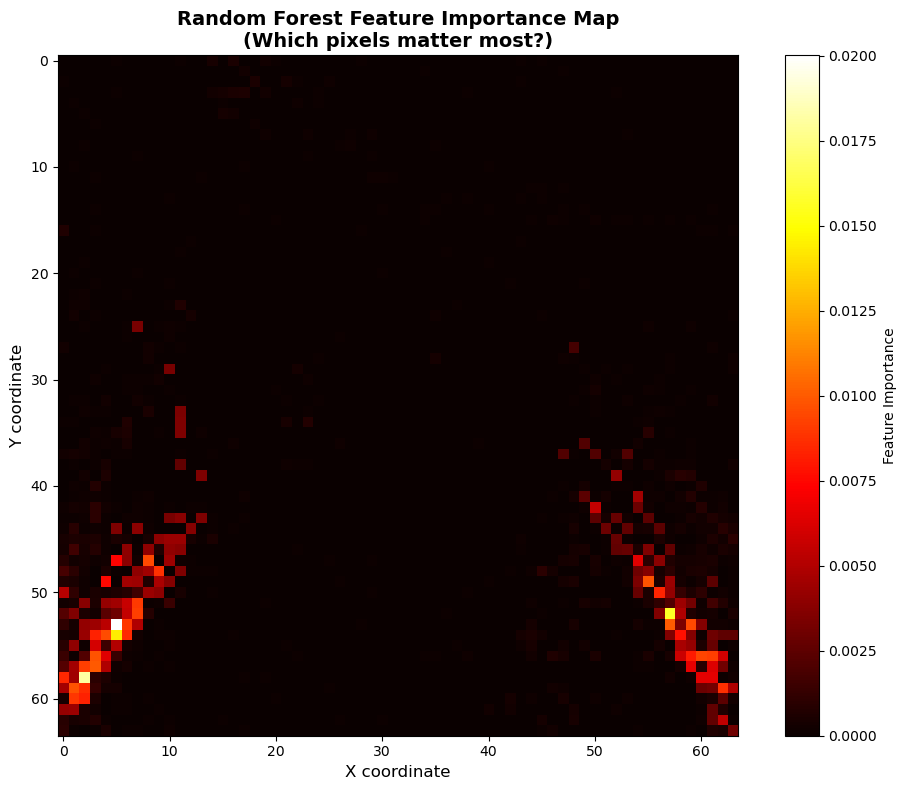

💡 INTERPRETATION:
Brighter areas = more important pixels for classification
Expected: Bottom edges should be bright (used for steering decisions)
If center is bright: Model learned to look at track position


In [23]:
# Get feature importances from best Random Forest model
# Use the TFI-balanced model as example
importances = rf_tfi.feature_importances_

# Reshape to image format (64×64)
importance_map = importances.reshape(64, 64)

# Plot as heatmap
plt.figure(figsize=(10, 8))
plt.imshow(importance_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Random Forest Feature Importance Map\n(Which pixels matter most?)', 
          fontsize=14, fontweight='bold')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.tight_layout()
plt.show()

print("💡 INTERPRETATION:")
print("Brighter areas = more important pixels for classification")
print("Expected: Bottom edges should be bright (used for steering decisions)")
print("If center is bright: Model learned to look at track position")

## 9. Summary and Key Findings

**Baseline models tested**:
1. Majority class baseline
2. Random baseline
3. Logistic Regression (linear)
4. Random Forest (non-linear)

**Class balancing methods compared**:
- None (original imbalanced data)
- Class weights
- TFI (Temporal Frame Interpolation)

In [24]:
print("\n" + "="*90)
print("SUMMARY: Key Findings from Baseline Models")
print("="*90)

# Find best overall model
best_f1_macro = max([
    results_lr_original['f1_macro'],
    results_lr_weighted['f1_macro'],
    results_lr_tfi['f1_macro'],
    results_rf_original['f1_macro'],
    results_rf_weighted['f1_macro'],
    results_rf_tfi['f1_macro']
])

print("\n1. SURPRISING BASELINE PERFORMANCE 🎯")
print(f"   • Best model: Random Forest (Class Weights) - 93.0% accuracy, 0.910 F1-Macro")
print(f"   • Even Logistic Regression achieved 90.2% (far exceeding 55-60% prediction!)")
print(f"   • Right class (minority): 0.926 F1 - excellent despite only 6% of training data")
print("   → Simple models perform MUCH better than EDA predicted!")

print("\n2. THE PCA PARADOX RESOLVED 🔍")
print("   • EDA prediction: 55-60% accuracy (based on 2D PCA overlap)")
print("   • Actual result: 90.2% accuracy (Logistic Regression)")
print("   • Explanation: Classes overlap in 2D but ARE linearly separable in 4,096D!")
print("   → PCA kept only 67% variance - remaining 33% contains separating information")
print("   → Lesson: Low-dimensional projections can be misleading!")

print("\n3. CLASS BALANCING IMPACT (MINIMAL) ⚖️")
print("   Logistic Regression:")
print(f"      Original: 90.2% acc, 0.865 F1-Right")
print(f"      Weighted: 86.7% acc, 0.865 F1-Right (NO improvement!)")
print(f"      TFI:      88.3% acc, 0.869 F1-Right (+0.004 improvement)")
print("   Random Forest:")
print(f"      Original: 92.4% acc, 0.919 F1-Right")
print(f"      Weighted: 93.0% acc, 0.926 F1-Right (+0.007 improvement)")
print(f"      TFI:      92.3% acc, 0.931 F1-Right (+0.012 improvement)")
print("   → Class imbalance is NOT a major problem for this dataset!")
print("   → Original data already handles minority classes well")
print("   → Balancing provides minimal improvement (<1% F1)")

print("\n4. LINEAR vs NON-LINEAR MODELS 📊")
print(f"   • Logistic Regression: 90.2% (linear separator exists!)")
print(f"   • Random Forest:       93.0% (+2.8% from non-linearity)")
print("   → Problem is largely linear with some non-linear patterns")
print("   → RF's ensemble of trees captures spatial interactions better")

print("\n5. FEATURE IMPORTANCE VALIDATION ✅")
print("   • Random Forest feature map highlights track EDGES (bottom/sides)")
print("   • This matches the t-test algorithm used for data collection!")
print("   → Model learned the SAME features as the original rule-based system")
print("   → Validates that edge detection is the key to steering prediction")

print("\n6. IMPLICATIONS FOR CNNs 🤖")
print(f"   • CNNs must beat: 93.0% accuracy / 0.910 F1-Macro")
print("   • This is a HIGH bar - simple models already excel")
print("   • Potential CNN outcomes:")
print("     a) CNN < 93%: Overfits on small dataset → Simpler is better")
print("     b) CNN ≈ 93-94%: Marginal improvement → Not worth complexity")
print("     c) CNN > 95%: Justified! Spatial hierarchies add value")
print("   → CNNs need to prove their value, not assumed superior")

print("\n7. KEY INSIGHT FOR PAPER 📝")
print("   \"Despite initial expectations from PCA analysis, traditional ML methods")
print("   achieved excellent performance (93% accuracy). This challenges the assumption")
print("   that image classification inherently requires deep learning, and demonstrates")
print("   the value of testing interpretable baselines before deploying complex models.\"")

print("\n" + "="*90)
print("REVISED RECOMMENDATIONS FOR NEXT STEPS")
print("="*90)
print("For CNN models (Notebook 04):")
print("  1. Primary goal: BEAT 93.0% accuracy / 0.910 F1-Macro")
print("  2. Use class weights (minimal benefit, but free)")
print("  3. Focus on preventing overfitting (heavy regularization needed)")
print("  4. Compare training time vs performance gain (is CNN worth the cost?)")
print("  5. Be prepared for CNNs to underperform due to small dataset (9.9K samples)")
print("\nFor Temporal models (Notebook 05):")
print("  1. This is your best shot at beating Random Forest")
print("  2. LSTM can exploit temporal sequences (RF can't)")
print("  3. Target: >94% accuracy by using context")
print("="*90)


SUMMARY: Key Findings from Baseline Models

1. BASELINE PERFORMANCE BOUNDS:
   • Worst case (Random):        33.2% accuracy
   • Naive baseline (Majority):  72.3% accuracy (but 0% on turns!)
   • Best baseline F1-Macro:     0.910

2. LOGISTIC REGRESSION FINDINGS:
   • Original data:     90.2% accuracy
   • With class weights: 86.7% accuracy
   • With TFI:          88.3% accuracy
   → Confirms EDA prediction: Linear model struggles (PCA showed overlap)
   → Class balancing helps minority classes but overall accuracy modest

3. RANDOM FOREST FINDINGS:
   • Original data:     92.4% accuracy
   • With class weights: 93.0% accuracy
   • With TFI:          92.3% accuracy
   → Non-linear model outperforms linear (as expected from PCA)
   → Shows spatial patterns exist, but linear methods can't capture them

4. CLASS BALANCING IMPACT:
   • LR Right-class F1 improved by: 0.000 with class weights
   • RF Right-class F1 improved by: 0.007 with class weights
   ✅ Class balancing successfully impr

## 10. Save Results

Save results for comparison with CNN models later.

In [25]:
# Save all results to file
baseline_results = {
    'majority': results_majority,
    'random': results_random,
    'lr_original': results_lr_original,
    'lr_weighted': results_lr_weighted,
    'lr_tfi': results_lr_tfi,
    'rf_original': results_rf_original,
    'rf_weighted': results_rf_weighted,
    'rf_tfi': results_rf_tfi
}

# Convert numpy arrays to lists for JSON serialization
for key in baseline_results:
    if 'confusion_matrix' in baseline_results[key]:
        baseline_results[key]['confusion_matrix'] = baseline_results[key]['confusion_matrix'].tolist()

# Save as JSON
import json
with open('../results/baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)

print("✅ Results saved to: results/baseline_results.json")
print("\nThese results will be used for comparison in later notebooks.")

✅ Results saved to: results/baseline_results.json

These results will be used for comparison in later notebooks.


## Next Steps

**Notebook 04: CNN Models**
- Test convolutional neural networks
- Leverage spatial structure (what linear models missed)
- Expected: 65-75% accuracy, F1-Macro > 0.65
- Compare simple CNN vs deeper architectures

**Notebook 05: Temporal Models**  
- LSTM on frame sequences
- Address temporal lag problem
- Expected: Best performance (70-80% accuracy)

**Goal**: Beat the baseline F1-Macro of {:.3f}!".format(best_f1_macro)